# SYMFLUENCE Tutorial 02c — Basin-Scale Workflow (Bow River at Banff, Elevation-Based Distributed)

## Introduction

This tutorial demonstrates the most spatially-detailed modeling approach: elevation-based HRU discretization. Building on Tutorials 02a (lumped) and 02b (semi-distributed), we now subdivide each GRU into elevation bands that capture altitudinal controls on mountain hydrology.

Elevation-based discretization is critical in mountain watersheds where temperature and precipitation vary systematically with altitude. By stratifying each sub-basin into elevation bands, we better represent snowpack dynamics, seasonal timing differences, and orographic effects.

The key configuration parameter is `ELEVATION_BAND_SIZE`, which controls the vertical resolution (e.g., 100m bands). Smaller bands increase spatial detail but add computational cost. This approach maintains the validated GRU structure from Tutorial 02b while adding vertical stratification.

For the **Bow River at Banff** (elevation range: 1,384–3,400 m), elevation bands capture the transition from low-elevation rain-dominated zones to high-elevation snow-dominated headwaters, improving simulation of spring freshet timing and runoff generation.


# Step 1 — Configuration and data reuse

We configure elevation-based discretization and reuse data from Tutorial 02b where possible.

In [1]:
# Step 1 — Elevation-based configuration with data reuse

from pathlib import Path
import yaml
import shutil
import sys

# Find SYMFLUENCE root by searching upward for 0_config_files directory
def find_symfluence_root():
    current = Path.cwd().resolve()  # Get absolute path
    
    # Search upward, skipping any .ipynb_checkpoints directories
    for i in range(30):  # Search up to 30 levels
        # Skip if this path contains .ipynb_checkpoints
        if '.ipynb_checkpoints' in str(current):
            if current.parent == current:  # Reached filesystem root
                break
            current = current.parent
            continue
            
        # Check if this is the root (has 0_config_files)
        if (current / '0_config_files').exists():
            # Double-check we're not in a checkpoint directory
            if '.ipynb_checkpoints' not in str(current):
                print(f"Found SYMFLUENCE root: {current}")
                return current
            else:
                current = current.parent
                continue
            
        # Move up
        if current.parent == current:  # Reached filesystem root
            break
        current = current.parent
    
    raise FileNotFoundError(f"Could not find SYMFLUENCE root (0_config_files directory). Last path checked: {current}")

SYMFLUENCE_CODE_DIR = find_symfluence_root()

sys.path.append(str(SYMFLUENCE_CODE_DIR))
from symfluence import SYMFLUENCE

# Load template to get the correct SYMFLUENCE_DATA_DIR
config_template = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'
with open(config_template, 'r') as f:
    template_config = yaml.safe_load(f)

# Use SYMFLUENCE_DATA_DIR from template
SYMFLUENCE_DATA_DIR = Path(template_config.get('SYMFLUENCE_DATA_DIR', 
                                                 str(SYMFLUENCE_CODE_DIR.parent / 'data' / 'SYMFLUENCE_data'))).resolve()

print(f"Using SYMFLUENCE_DATA_DIR: {SYMFLUENCE_DATA_DIR}")

# Load template again for config creation
with open(config_template, 'r') as f:
    config = yaml.safe_load(f)

# === Modify for elevation-based distributed ===
config['SYMFLUENCE_CODE_DIR'] = str(SYMFLUENCE_CODE_DIR)
config['SYMFLUENCE_DATA_DIR'] = str(SYMFLUENCE_DATA_DIR)
config['DOMAIN_NAME'] = 'Bow_at_Banff_elevation'
config['EXPERIMENT_ID'] = 'run_1'
config['POUR_POINT_COORDS'] = '51.1722/-115.5717'

# Elevation-based discretization
config['DOMAIN_DEFINITION_METHOD'] = 'delineate'
config['STREAM_THRESHOLD'] = 5000  # Same as 02b
config['DOMAIN_DISCRETIZATION'] = 'elevation'  # Key change
config['ELEVATION_BAND_SIZE'] = 400  # 400m elevation bands

config['HYDROLOGICAL_MODEL'] = 'SUMMA'
config['ROUTING_MODEL'] = 'mizuRoute'
config['MIZU_FROM_MODEL'] = 'SUMMA'

config['SETTINGS_MIZU_ROUTING_VAR'] = 'averageRoutedRunoff'
config['SETTINGS_MIZU_ROUTING_UNITS'] = 'm/s'
config['SETTINGS_MIZU_ROUTING_DT'] = '3600'

# Temporal extent
config['EXPERIMENT_TIME_START'] = '2004-01-01 01:00'
config['EXPERIMENT_TIME_END'] = '2007-12-31 23:00'
config['CALIBRATION_PERIOD'] = '2005-10-01, 2006-09-30'
config['EVALUATION_PERIOD'] = '2006-10-01, 2007-12-30'
config['SPINUP_PERIOD'] = '2004-01-01, 2005-09-30'

config['STATION_ID'] = '05BB001'
config['DOWNLOAD_WSC_DATA'] = True

config['PARAMS_TO_CALIBRATE'] = 'minStomatalResistance,cond2photo_slope,vcmax25_canopyTop,jmax25_scale,summerLAI,rootingDepth,soilStressParam,z0Canopy,windReductionParam'
config['OPTIMIZATION_TARGET'] = 'streamflow'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'KGE'
config['CALIBRATION_TIMESTEP'] = 'hourly'  

# Save configuration to 0_config_files directory
config_path = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_elevation_distributed.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ Configuration saved: {config_path}")

# === Data reuse from Tutorial 02b ===
semi_dist_domain = 'Bow_at_Banff_semi_distributed'
semi_dist_data_dir = SYMFLUENCE_DATA_DIR / f'domain_{semi_dist_domain}'

def copy_with_name_adaptation(src, dst, old_name, new_name):
    """Copy directory and adapt filenames"""
    if not src.exists():
        return False
    dst.parent.mkdir(parents=True, exist_ok=True)
    if src.is_file():
        shutil.copy2(src, dst)
        return True
    shutil.copytree(src, dst, dirs_exist_ok=True)
    for file in dst.rglob('*'):
        if file.is_file() and old_name in file.name:
            new_file = file.parent / file.name.replace(old_name, new_name)
            file.rename(new_file)
    return True

# Initialize SYMFLUENCE
symfluence = SYMFLUENCE(config_path)
project_dir = symfluence.managers['project'].setup_project()

if semi_dist_data_dir.exists():
    print(f"\n📋 Reusing data from Tutorial 02b: {semi_dist_data_dir}")
    
    reusable_data = {
        'Elevation': semi_dist_data_dir / 'attributes' / 'elevation',
        'Land Cover': semi_dist_data_dir / 'attributes' / 'landclass',
        'Soils': semi_dist_data_dir / 'attributes' / 'soilclass',
        'Forcing': semi_dist_data_dir / 'forcing' / 'raw_data',
        'Stream Network': semi_dist_data_dir / 'shapefiles' / 'river_network',
        'GRUs': semi_dist_data_dir / 'shapefiles' / 'river_basins',
        'Streamflow': semi_dist_data_dir / 'observations' / 'streamflow'
    }
    
    for data_type, src_path in reusable_data.items():
        if src_path.exists():
            rel_path = src_path.relative_to(semi_dist_data_dir)
            dst_path = project_dir / rel_path
            success = copy_with_name_adaptation(src_path, dst_path, semi_dist_domain, config['DOMAIN_NAME'])
            if success:
                print(f"   ✅ {data_type}: Copied")
        else:
            print(f"   📋 {data_type}: Not found")
else:
    print(f"\n⚠️  No data from Tutorial 02b found at: {semi_dist_data_dir}")
    print(f"   Will acquire fresh data.")

# Create pour point
pour_point_path = symfluence.managers['project'].create_pour_point()
print(f"\n✅ Project structure created at: {project_dir}")

Found SYMFLUENCE root: /Users/darrieythorsson/compHydro/code/SYMFLUENCE
Using SYMFLUENCE_DATA_DIR: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data
✅ Configuration saved: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_elevation_distributed.yaml
2025-12-31 14:48:43 ● SYMFLUENCE Logging Initialized
2025-12-31 14:48:43 ● Domain: Bow_at_Banff_elevation
2025-12-31 14:48:43 ● Experiment ID: run_1
2025-12-31 14:48:43 ● Log Level: INFO
2025-12-31 14:48:43 ● Log File: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/symfluence_general_Bow_at_Banff_elevation_20251231_144843.log
2025-12-31 14:48:43 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/config_Bow_at_Banff_elevation_20251231_144843.yaml
2025-12-31 14:48:43 ● SYMFLUENCE initialized with config: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config

## Step 2 — Elevation-based discretization

Subdivide each GRU from Tutorial 02b into elevation bands for vertical stratification.

### Step 2a — Attribute check

Verify DEM and GRU availability from data reuse.

In [2]:
# Step 2a — DEM and GRU availability check
dem_path = project_dir / 'attributes' / 'elevation' / 'dem'
gru_path = project_dir / 'shapefiles' / 'river_basins'

if not dem_path.exists() or not gru_path.exists():
    print("   Required data not found, acquiring...")
    # If using MAF supported HPC, uncomment the lines below
    # symfluence.managers['data'].acquire_attributes()
    # symfluence.managers['domain'].define_domain()
    print("✅ Geospatial data acquired")
else:
    print("✅ DEM and GRU data available from previous workflow")

✅ DEM and GRU data available from previous workflow


### Step 2b — Elevation band creation

Create HRUs by intersecting GRUs with elevation bands.

In [3]:
# Step 2b — Elevation-based HRU discretization
hru_path = symfluence.managers['domain'].discretize_domain()
print("✅ Elevation-based HRU discretization complete")

2025-12-31 14:48:43 ● Discretizing domain using method: elevation
2025-12-31 14:48:43 ● Starting domain discretization using attributes: ['elevation']
Step 1/2: Running single attribute discretization method
2025-12-31 14:48:43 ● Raster info: 1260x972 pixels, nodata=-9999.0
2025-12-31 14:48:43 ● Valid data range: 787.10 to 3527.50
2025-12-31 14:48:43 ● Total valid pixels: 1224720
2025-12-31 14:48:43 ● Created 7 bands with size 400.0
2025-12-31 14:48:43 ● Threshold range: 787.10 to 3587.10
2025-12-31 14:48:43 ● Creating HRUs within 49 GRUs based on elevClass
2025-12-31 14:48:43 ● Processing GRU 1/49
2025-12-31 14:48:43 ● Processing GRU 2/49
2025-12-31 14:48:43 ● Processing GRU 3/49
2025-12-31 14:48:43 ● Processing GRU 4/49
2025-12-31 14:48:43 ● Processing GRU 5/49
2025-12-31 14:48:43 ● Processing GRU 6/49
2025-12-31 14:48:43 ● Processing GRU 7/49
2025-12-31 14:48:43 ● Processing GRU 8/49
2025-12-31 14:48:43 ● Processing GRU 9/49
2025-12-31 14:48:43 ● Processing GRU 10/49
2025-12-31 14:4

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/src/symfluence/utils/geospatial/discretization_utils.py:789: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hru_gdf.to_file(output_shapefile)
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'avg_elevclass' to 'avg_elevcl'
  ogr_write(


2025-12-31 14:48:45 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/plots/catchment/Bow_at_Banff_elevation_HRUs_elevation.png
Step 2/2: Sorting catchment shape
2025-12-31 14:48:45 ● Sorting catchment shape
2025-12-31 14:48:45 ● Catchment shape sorted and saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment/Bow_at_Banff_elevation_HRUs_elevation.shp
2025-12-31 14:48:45 ● Domain discretization completed in 1.78 seconds
2025-12-31 14:48:45 ● Creating discretization visualization...
2025-12-31 14:48:45 ● Discretization map saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/plots/discretization/domain_discretization_elevation.png
✅ Elevation-based HRU discretization complete


### Step 2c — Elevation structure visualization

Visualize the elevation-stratified HRU structure.

Number of elevation-based HRUs: 216
Elevation range: 1418 - 3313 m


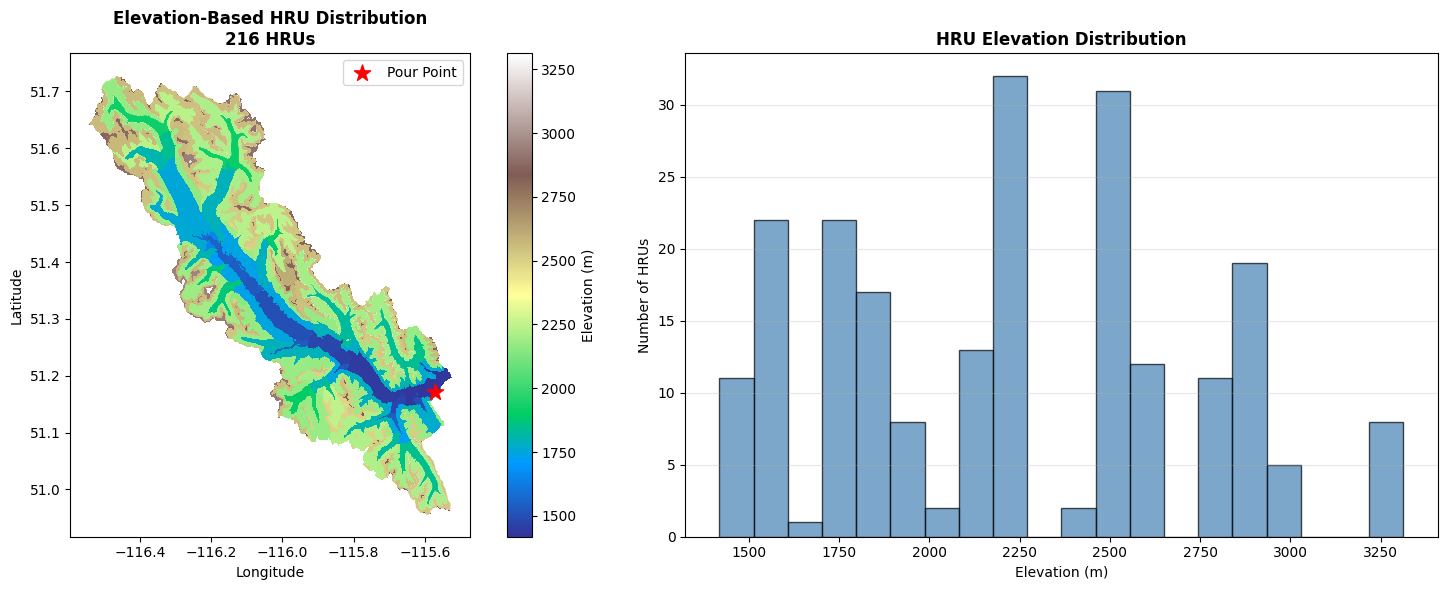

In [4]:
# Step 2c — Elevation band visualization

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load HRUs with elevation information
hru_file = project_dir / 'shapefiles' / 'catchment' / f"{config['DOMAIN_NAME']}_HRUs_elevation.shp"

if hru_file.exists():
    hru_gdf = gpd.read_file(str(hru_file))
    print(f"Number of elevation-based HRUs: {len(hru_gdf)}")
    
    # Calculate elevation statistics
    if 'elev_mean' in hru_gdf.columns:
        elev_col = 'elev_mean'
    elif 'elevation' in hru_gdf.columns:
        elev_col = 'elevation'
    else:
        elev_col = hru_gdf.select_dtypes(include=[np.number]).columns[0]
    
    print(f"Elevation range: {hru_gdf[elev_col].min():.0f} - {hru_gdf[elev_col].max():.0f} m")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Spatial map colored by elevation
    hru_gdf.plot(column=elev_col, cmap='terrain', ax=axes[0], 
                 legend=True, legend_kwds={'label': 'Elevation (m)'})
    
    pour_point_gdf = gpd.read_file(pour_point_path)
    pour_point_gdf.plot(ax=axes[0], color='red', markersize=150, marker='*', label='Pour Point')
    
    axes[0].set_title(f'Elevation-Based HRU Distribution\n{len(hru_gdf)} HRUs', fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].legend()
    
    # Elevation distribution histogram
    axes[1].hist(hru_gdf[elev_col], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Elevation (m)')
    axes[1].set_ylabel('Number of HRUs')
    axes[1].set_title('HRU Elevation Distribution', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  HRU shapefile not found")

## Step 3 — Data preprocessing

Process forcing and observation data for elevation-stratified HRUs.

In [5]:
# Step 3a — Streamflow observations
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].process_observed_data()
print("✅ Streamflow data processing complete")

✅ Streamflow data processing complete


In [6]:
# Step 3b — Forcing data
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].acquire_forcings()
print("✅ Forcing acquisition complete")

✅ Forcing acquisition complete


In [7]:
# Step 3c — Model-agnostic preprocessing
symfluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

2025-12-31 14:48:46 ● Starting model-agnostic preprocessing
2025-12-31 14:48:46 ● Running geospatial statistics
2025-12-31 14:48:46 ● Starting geospatial statistics calculation
2025-12-31 14:48:46 ● Calculating soil statistics
2025-12-31 14:48:46 ● Soil raster CRS: EPSG:4326
2025-12-31 14:48:46 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 14:48:46 ● CRS match - no reprojection needed
2025-12-31 14:48:46 ● Soil statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
2025-12-31 14:48:46 ● Calculating land statistics
2025-12-31 14:48:46 ● Land raster CRS: EPSG:4326
2025-12-31 14:48:46 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 14:48:46 ● CRS match - no reprojection needed
2025-12-31 14:48:46 ● Land statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_landclass/catchmen

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_elevClass' to 'S_1_elevCl'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_avg_elevcl' to 'S_1_avg_el'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw

EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped n

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200402.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200402.nc 
Started at date and time 2025-12-31 14:48:52.331424 
Ended at date and time 2025-12-31 14:48:56.447628 
It took 4.116204 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:56 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200402.nc (2/48)
2025-12-31 14:48:56 ● Processing file 3/48: domain_Bow_at_Banff_elevation_ERA5_merged_200403.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200403.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200403.nc 
Started at date and time 2025-12-31 14:48:56.477032 
Ended at date and time 2025-12-31 14:49:00.906054 
It took 4.429022 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:00 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200403.nc (3/48)
2025-12-31 14:49:00 ● Processing file 4/48: domain_Bow_at_Banff_elevation_ERA5_merged_200404.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200404.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200404.nc 
Started at date and time 2025-12-31 14:49:00.934639 
Ended at date and time 2025-12-31 14:49:05.173978 
It took 4.239339 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:05 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200404.nc (4/48)
2025-12-31 14:49:05 ● Processing file 5/48: domain_Bow_at_Banff_elevation_ERA5_merged_200405.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200405.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200405.nc 
Started at date and time 2025-12-31 14:49:05.202660 
Ended at date and time 2025-12-31 14:49:09.621307 
It took 4.418647 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:09 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200405.nc (5/48)
2025-12-31 14:49:09 ● Processing file 6/48: domain_Bow_at_Banff_elevation_ERA5_merged_200406.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200406.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200406.nc 
Started at date and time 2025-12-31 14:49:09.653047 
Ended at date and time 2025-12-31 14:49:13.917610 
It took 4.264563 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:13 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200406.nc (6/48)
2025-12-31 14:49:13 ● Processing file 7/48: domain_Bow_at_Banff_elevation_ERA5_merged_200407.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200407.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200407.nc 
Started at date and time 2025-12-31 14:49:13.946726 
Ended at date and time 2025-12-31 14:49:18.299365 
It took 4.352639 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:18 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200407.nc (7/48)
2025-12-31 14:49:18 ● Processing file 8/48: domain_Bow_at_Banff_elevation_ERA5_merged_200408.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200408.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200408.nc 
Started at date and time 2025-12-31 14:49:18.329689 
Ended at date and time 2025-12-31 14:49:22.669177 
It took 4.339488 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:22 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200408.nc (8/48)
2025-12-31 14:49:22 ● Processing file 9/48: domain_Bow_at_Banff_elevation_ERA5_merged_200409.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided;

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200409.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200409.nc 
Started at date and time 2025-12-31 14:49:22.699499 
Ended at date and time 2025-12-31 14:49:26.883860 
It took 4.184361 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:26 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200409.nc (9/48)
2025-12-31 14:49:26 ● Processing file 10/48: domain_Bow_at_Banff_elevation_ERA5_merged_200410.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200410.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200410.nc 
Started at date and time 2025-12-31 14:49:26.914539 
Ended at date and time 2025-12-31 14:49:31.206359 
It took 4.29182 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:31 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200410.nc (10/48)
2025-12-31 14:49:31 ● Progress: 10/48 files processed (10 successful)
2025-12-31 14:49:31 ● Processing file 11/48: domain_Bow_at_Banff_elevation_ERA5_merged_200411.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and f

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200411.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200411.nc 
Started at date and time 2025-12-31 14:49:31.236138 
Ended at date and time 2025-12-31 14:49:35.422257 
It took 4.186119 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:35 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200411.nc (11/48)
2025-12-31 14:49:35 ● Processing file 12/48: domain_Bow_at_Banff_elevation_ERA5_merged_200412.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200412.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200412.nc 
Started at date and time 2025-12-31 14:49:35.454148 
Ended at date and time 2025-12-31 14:49:39.813451 
It took 4.359303 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:39 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200412.nc (12/48)
2025-12-31 14:49:39 ● Processing file 13/48: domain_Bow_at_Banff_elevation_ERA5_merged_200501.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200501.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200501.nc 
Started at date and time 2025-12-31 14:49:39.845672 
Ended at date and time 2025-12-31 14:49:44.345409 
It took 4.499737 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:44 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200501.nc (13/48)
2025-12-31 14:49:44 ● Processing file 14/48: domain_Bow_at_Banff_elevation_ERA5_merged_200502.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200502.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200502.nc 
Started at date and time 2025-12-31 14:49:44.375759 
Ended at date and time 2025-12-31 14:49:48.273995 
It took 3.898236 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:48 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200502.nc (14/48)
2025-12-31 14:49:48 ● Processing file 15/48: domain_Bow_at_Banff_elevation_ERA5_merged_200503.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200503.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200503.nc 
Started at date and time 2025-12-31 14:49:48.304854 
Ended at date and time 2025-12-31 14:49:52.688417 
It took 4.383563 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:52 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200503.nc (15/48)
2025-12-31 14:49:52 ● Processing file 16/48: domain_Bow_at_Banff_elevation_ERA5_merged_200504.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200504.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200504.nc 
Started at date and time 2025-12-31 14:49:52.717896 
Ended at date and time 2025-12-31 14:49:57.022895 
It took 4.304999 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:57 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200504.nc (16/48)
2025-12-31 14:49:57 ● Processing file 17/48: domain_Bow_at_Banff_elevation_ERA5_merged_200505.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200505.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200505.nc 
Started at date and time 2025-12-31 14:49:57.056039 
Ended at date and time 2025-12-31 14:50:01.429261 
It took 4.373222 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:01 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200505.nc (17/48)
2025-12-31 14:50:01 ● Processing file 18/48: domain_Bow_at_Banff_elevation_ERA5_merged_200506.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200506.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200506.nc 
Started at date and time 2025-12-31 14:50:01.461541 
Ended at date and time 2025-12-31 14:50:05.735266 
It took 4.273725 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:05 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200506.nc (18/48)
2025-12-31 14:50:05 ● Processing file 19/48: domain_Bow_at_Banff_elevation_ERA5_merged_200507.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200507.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200507.nc 
Started at date and time 2025-12-31 14:50:05.764820 
Ended at date and time 2025-12-31 14:50:10.295082 
It took 4.530262 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:10 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200507.nc (19/48)
2025-12-31 14:50:10 ● Processing file 20/48: domain_Bow_at_Banff_elevation_ERA5_merged_200508.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200508.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200508.nc 
Started at date and time 2025-12-31 14:50:10.325909 
Ended at date and time 2025-12-31 14:50:14.623561 
It took 4.297652 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:14 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200508.nc (20/48)
2025-12-31 14:50:14 ● Progress: 20/48 files processed (20 successful)
2025-12-31 14:50:14 ● Processing file 21/48: domain_Bow_at_Banff_elevation_ERA5_merged_200509.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200509.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200509.nc 
Started at date and time 2025-12-31 14:50:14.653414 
Ended at date and time 2025-12-31 14:50:18.862495 
It took 4.209081 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:18 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200509.nc (21/48)
2025-12-31 14:50:18 ● Processing file 22/48: domain_Bow_at_Banff_elevation_ERA5_merged_200510.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200510.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200510.nc 
Started at date and time 2025-12-31 14:50:18.891663 
Ended at date and time 2025-12-31 14:50:23.133946 
It took 4.242283 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:23 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200510.nc (22/48)
2025-12-31 14:50:23 ● Processing file 23/48: domain_Bow_at_Banff_elevation_ERA5_merged_200511.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200511.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200511.nc 
Started at date and time 2025-12-31 14:50:23.165796 
Ended at date and time 2025-12-31 14:50:27.217821 
It took 4.052025 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:27 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200511.nc (23/48)
2025-12-31 14:50:27 ● Processing file 24/48: domain_Bow_at_Banff_elevation_ERA5_merged_200512.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200512.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200512.nc 
Started at date and time 2025-12-31 14:50:27.247146 
Ended at date and time 2025-12-31 14:50:31.773161 
It took 4.526015 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:31 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200512.nc (24/48)
2025-12-31 14:50:31 ● Processing file 25/48: domain_Bow_at_Banff_elevation_ERA5_merged_200601.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200601.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200601.nc 
Started at date and time 2025-12-31 14:50:31.808543 
Ended at date and time 2025-12-31 14:50:36.190560 
It took 4.382017 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:36 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200601.nc (25/48)
2025-12-31 14:50:36 ● Processing file 26/48: domain_Bow_at_Banff_elevation_ERA5_merged_200602.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200602.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200602.nc 
Started at date and time 2025-12-31 14:50:36.223592 
Ended at date and time 2025-12-31 14:50:40.374634 
It took 4.151042 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:40 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200602.nc (26/48)
2025-12-31 14:50:40 ● Processing file 27/48: domain_Bow_at_Banff_elevation_ERA5_merged_200603.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200603.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200603.nc 
Started at date and time 2025-12-31 14:50:40.410719 
Ended at date and time 2025-12-31 14:50:44.888395 
It took 4.477676 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:44 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200603.nc (27/48)
2025-12-31 14:50:44 ● Processing file 28/48: domain_Bow_at_Banff_elevation_ERA5_merged_200604.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200604.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200604.nc 
Started at date and time 2025-12-31 14:50:44.917597 
Ended at date and time 2025-12-31 14:50:49.174271 
It took 4.256674 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:49 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200604.nc (28/48)
2025-12-31 14:50:49 ● Processing file 29/48: domain_Bow_at_Banff_elevation_ERA5_merged_200605.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200605.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200605.nc 
Started at date and time 2025-12-31 14:50:49.203987 
Ended at date and time 2025-12-31 14:50:53.492356 
It took 4.288369 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:53 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200605.nc (29/48)
2025-12-31 14:50:53 ● Processing file 30/48: domain_Bow_at_Banff_elevation_ERA5_merged_200606.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200606.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200606.nc 
Started at date and time 2025-12-31 14:50:53.529918 
Ended at date and time 2025-12-31 14:50:57.784882 
It took 4.254964 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:57 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200606.nc (30/48)
2025-12-31 14:50:57 ● Progress: 30/48 files processed (30 successful)
2025-12-31 14:50:57 ● Processing file 31/48: domain_Bow_at_Banff_elevation_ERA5_merged_200607.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200607.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200607.nc 
Started at date and time 2025-12-31 14:50:57.815233 
Ended at date and time 2025-12-31 14:51:02.072139 
It took 4.256906 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:02 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200607.nc (31/48)
2025-12-31 14:51:02 ● Processing file 32/48: domain_Bow_at_Banff_elevation_ERA5_merged_200608.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200608.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200608.nc 
Started at date and time 2025-12-31 14:51:02.102212 
Ended at date and time 2025-12-31 14:51:06.313552 
It took 4.21134 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:06 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200608.nc (32/48)
2025-12-31 14:51:06 ● Processing file 33/48: domain_Bow_at_Banff_elevation_ERA5_merged_200609.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200609.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200609.nc 
Started at date and time 2025-12-31 14:51:06.343012 
Ended at date and time 2025-12-31 14:51:10.392615 
It took 4.049603 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:10 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200609.nc (33/48)
2025-12-31 14:51:10 ● Processing file 34/48: domain_Bow_at_Banff_elevation_ERA5_merged_200610.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200610.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200610.nc 
Started at date and time 2025-12-31 14:51:10.423127 
Ended at date and time 2025-12-31 14:51:14.627007 
It took 4.20388 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:14 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200610.nc (34/48)
2025-12-31 14:51:14 ● Processing file 35/48: domain_Bow_at_Banff_elevation_ERA5_merged_200611.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200611.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200611.nc 
Started at date and time 2025-12-31 14:51:14.656176 
Ended at date and time 2025-12-31 14:51:18.711933 
It took 4.055757 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:18 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200611.nc (35/48)
2025-12-31 14:51:18 ● Processing file 36/48: domain_Bow_at_Banff_elevation_ERA5_merged_200612.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200612.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200612.nc 
Started at date and time 2025-12-31 14:51:18.740544 
Ended at date and time 2025-12-31 14:51:22.926591 
It took 4.186047 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:22 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200612.nc (36/48)
2025-12-31 14:51:22 ● Processing file 37/48: domain_Bow_at_Banff_elevation_ERA5_merged_200701.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200701.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200701.nc 
Started at date and time 2025-12-31 14:51:22.955698 
Ended at date and time 2025-12-31 14:51:27.280062 
It took 4.324364 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:27 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200701.nc (37/48)
2025-12-31 14:51:27 ● Processing file 38/48: domain_Bow_at_Banff_elevation_ERA5_merged_200702.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200702.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200702.nc 
Started at date and time 2025-12-31 14:51:27.311227 
Ended at date and time 2025-12-31 14:51:31.167810 
It took 3.856583 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:31 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200702.nc (38/48)
2025-12-31 14:51:31 ● Processing file 39/48: domain_Bow_at_Banff_elevation_ERA5_merged_200703.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200703.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200703.nc 
Started at date and time 2025-12-31 14:51:31.199668 
Ended at date and time 2025-12-31 14:51:35.419224 
It took 4.219556 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:35 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200703.nc (39/48)
2025-12-31 14:51:35 ● Processing file 40/48: domain_Bow_at_Banff_elevation_ERA5_merged_200704.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200704.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200704.nc 
Started at date and time 2025-12-31 14:51:35.451153 
Ended at date and time 2025-12-31 14:51:39.539558 
It took 4.088405 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:39 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200704.nc (40/48)
2025-12-31 14:51:39 ● Progress: 40/48 files processed (40 successful)
2025-12-31 14:51:39 ● Processing file 41/48: domain_Bow_at_Banff_elevation_ERA5_merged_200705.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200705.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200705.nc 
Started at date and time 2025-12-31 14:51:39.571562 
Ended at date and time 2025-12-31 14:51:43.754058 
It took 4.182496 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:43 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200705.nc (41/48)
2025-12-31 14:51:43 ● Processing file 42/48: domain_Bow_at_Banff_elevation_ERA5_merged_200706.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200706.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200706.nc 
Started at date and time 2025-12-31 14:51:43.783231 
Ended at date and time 2025-12-31 14:51:47.898297 
It took 4.115066 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:47 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200706.nc (42/48)
2025-12-31 14:51:47 ● Processing file 43/48: domain_Bow_at_Banff_elevation_ERA5_merged_200707.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200707.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200707.nc 
Started at date and time 2025-12-31 14:51:47.927810 
Ended at date and time 2025-12-31 14:51:52.184658 
It took 4.256848 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:52 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200707.nc (43/48)
2025-12-31 14:51:52 ● Processing file 44/48: domain_Bow_at_Banff_elevation_ERA5_merged_200708.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200708.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200708.nc 
Started at date and time 2025-12-31 14:51:52.214713 
Ended at date and time 2025-12-31 14:51:56.513748 
It took 4.299035 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:56 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200708.nc (44/48)
2025-12-31 14:51:56 ● Processing file 45/48: domain_Bow_at_Banff_elevation_ERA5_merged_200709.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200709.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200709.nc 
Started at date and time 2025-12-31 14:51:56.545208 
Ended at date and time 2025-12-31 14:52:00.575497 
It took 4.030289 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:52:00 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200709.nc (45/48)
2025-12-31 14:52:00 ● Processing file 46/48: domain_Bow_at_Banff_elevation_ERA5_merged_200710.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200710.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200710.nc 
Started at date and time 2025-12-31 14:52:00.604414 
Ended at date and time 2025-12-31 14:52:04.766661 
It took 4.162247 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:52:04 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200710.nc (46/48)
2025-12-31 14:52:04 ● Processing file 47/48: domain_Bow_at_Banff_elevation_ERA5_merged_200711.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200711.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200711.nc 
Started at date and time 2025-12-31 14:52:04.797596 
Ended at date and time 2025-12-31 14:52:08.900225 
It took 4.102629 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:52:08 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200711.nc (47/48)
2025-12-31 14:52:08 ● Processing file 48/48: domain_Bow_at_Banff_elevation_ERA5_merged_200712.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provide

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_200712.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/forcing/basin_averaged_data/Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_200712.nc 
Started at date and time 2025-12-31 14:52:08.930657 
Ended at date and time 2025-12-31 14:52:13.157921 
It took 4.227264 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:52:13 ● ✓ Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_200712.nc (48/48)
2025-12-31 14:52:13 ● Processing complete: 48 files processed successfully out of 48
2025-12-31 14:52:13 ● Total files processed or skipped: 48 out of 48
2025-12-31 14:52:13 ● Forcing remapping process completed
2025-12-31 14:52:13 ● Forcing data resampling process completed
2025-12-31 14:52:13 ● Model-agnostic preprocess

## Step 4 — Model execution

Configure and run SUMMA-mizuRoute with elevation-stratified HRUs.

In [8]:
# Step 4a — Model configuration
symfluence.managers['model'].preprocess_models()
print("✅ Elevation-based model configuration complete")

2025-12-31 14:52:13 ● Starting model-specific preprocessing
2025-12-31 14:52:13 ● Starting SUMMA spatial preprocessing
2025-12-31 14:52:13 ● Starting memory-efficient temperature lapse rate and data step application
2025-12-31 14:52:13 ● Converting /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_forcing/Bow_at_Banff_elevation_ERA5_intersected_shapefile.shp to CSV format
2025-12-31 14:52:13 ● Successfully created /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_forcing/Bow_at_Banff_elevation_ERA5_intersected_shapefile.csv
2025-12-31 14:52:13 ● Loading topology data...
2025-12-31 14:52:13 ● Loaded topology data: 373 rows, 2.77 MB
2025-12-31 14:52:13 ● Found 48 forcing files to process
2025-12-31 14:52:13 ● Pre-calculating lapse rate corrections...
2025-12-31 14:52:13 ● Prepared lapse corrections for 216 HRUs
2025-12-31 14:52:13 ● Processing 

In [ ]:
# Step 4b — Model execution
print(f"Running {config['HYDROLOGICAL_MODEL']} with {config['ROUTING_MODEL']} ({len(hru_gdf)} elevation-based HRUs)...")
symfluence.managers['model'].run_models()
print("✅ Elevation-based distributed simulation complete")

Running SUMMA with mizuRoute (216 elevation-based HRUs)...
2025-12-31 14:52:24 ● Starting model runs
2025-12-31 14:52:24 ● Running model: SUMMA
2025-12-31 14:52:24 ● Starting SUMMA run
2025-12-31 14:52:24 ● Running SUMMA with LD_LIBRARY_PATH: 
2025-12-31 14:52:24 ● SUMMA binary: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/summa/bin/summa_sundials.exe
2025-12-31 14:52:24 ● File manager: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/fileManager.txt


## Step 5 — Evaluation

Compare elevation-based results against observations and previous approaches.

In [ ]:
# Step 5 — Elevation-based HRUs evaluation 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# ---------------------------
# 1) Observations (daily, tz-naive)
# ---------------------------
obs_path = project_dir / "observations" / "streamflow" / "preprocessed" / f"{config['DOMAIN_NAME']}_streamflow_processed.csv"
obs_df = pd.read_csv(obs_path, parse_dates=["datetime"]).set_index("datetime").sort_index()

# Make tz-naive if needed
if obs_df.index.tz is not None:
    obs_df.index = obs_df.index.tz_convert(None)

# Put obs on daily mean (change to .sum() if your obs file is daily volumes)
obs_daily = obs_df["discharge_cms"].resample("D").mean().rename("discharge_obs")

# ---------------------------
# 2) Simulation (select segment, daily, tz-naive)
# ---------------------------
routing_dir = project_dir / "simulations" / config["EXPERIMENT_ID"] / "mizuRoute"
sim_files = list(routing_dir.glob("*.nc"))  # allow any routed filename
if not sim_files:
    raise FileNotFoundError(f"No routed streamflow in: {routing_dir}")

ds = xr.open_dataset(sim_files[0], decode_times=False)

# Fix non-CF units on the time coordinate if needed
time_name = next((d for d in ds.dims if 'time' in d.lower()), 'time')
tvar = ds[time_name]
units = (tvar.attrs or {}).get('units', '')
cal = (tvar.attrs or {}).get('calendar', 'standard')

def _parse_ref_date(u):
    # Accepts "s since 1990-1-1 0:0:0" or "seconds since 1990-01-01 00:00:00"
    if 'since' not in u:
        return None, None
    unit_part, ref_part = u.split('since', 1)
    unit_part = unit_part.strip().lower()
    ref_part = ref_part.strip()
    # Normalize short forms
    unit_norm = {'s': 'seconds', 'sec': 'seconds', 'secs': 'seconds'}.get(unit_part, unit_part)
    return unit_norm, ref_part

unit_norm, ref = _parse_ref_date(units)

if unit_norm == 'seconds' and ref is not None:
    # Build a pandas datetime index
    ref_ts = pd.to_datetime(ref)
    # ensure numeric array (int/float)
    tvals = xr.apply_ufunc(lambda x: x.astype('float64'), tvar, dask='allowed')
    new_time = ref_ts + pd.to_timedelta(tvals, unit='s')
    # assign fixed, CF-friendly coordinate
    ds = ds.assign_coords({time_name: ('time', pd.DatetimeIndex(new_time.values))})
    # Optional: clean attrs to a CF-compliant string
    ds[time_name].attrs['units'] = f"seconds since {ref_ts.strftime('%Y-%m-%d %H:%M:%S')}"
    ds[time_name].attrs['calendar'] = cal
else:
    # If units are already CF-compliant or different, you can try decoding now
    try:
        ds = xr.decode_cf(ds)
    except Exception:
        pass  # fall back to naive numeric time if needed

var = ds["IRFroutedRunoff"]

# find time dimension
time_dim = next((d for d in var.dims if "time" in d.lower()), None)
if time_dim is None:
    raise RuntimeError("Could not find a time dimension in IRFroutedRunoff.")

# choose the (first) non-time dimension as the segment dim
seg_dims = [d for d in var.dims if d != time_dim]
if not seg_dims:
    sim_series = var  # 1D over time
else:
    seg_dim = seg_dims[0]

    # 1) count finite points per segment
    good_counts = xr.apply_ufunc(np.isfinite, var).sum(dim=time_dim)

    # 2) keep only segments with at least one finite value
    valid_mask = good_counts > 0
    if not bool(valid_mask.any()):
        raise RuntimeError(
            "All segments are NaN over time in IRFroutedRunoff. "
            "Check that you opened the mizuRoute file (not SUMMA), the variable name, "
            "and that the run produced non-empty routed flows."
        )

    var_valid = var.where(valid_mask, drop=True)

    # 3) select segment with highest mean (over valid data)
    seg_mean = var_valid.mean(time_dim, skipna=True)
    max_idx = seg_mean.argmax(dim=seg_dim)
    seg_id = seg_mean[seg_dim].isel({seg_dim: max_idx}).item()

    # 4) extract the time series for that segment (use original var to keep coordinates)
    sim_series = var.sel({seg_dim: seg_id})
    print(f"[02c] Selected segment dim: {seg_dim}, id: {seg_id}")
    
# Convert to pandas
sim_df = sim_series.to_series().sort_index()
if getattr(sim_df.index, "tz", None) is not None:
    sim_df.index = sim_df.index.tz_convert(None)

# Daily cadence (use .sum() if routed values are volumes per timestep)
sim_daily = sim_df.resample("D").mean().rename("discharge_sim")

# ---------------------------
# 3) Spinup: skip first year from simulation start
# ---------------------------
spinup_end = (sim_daily.index.min() + pd.DateOffset(years=1)).normalize()
print("Spinup ends at:", spinup_end)

obs_daily_trim = obs_daily.loc[obs_daily.index >= spinup_end]
sim_daily_trim = sim_daily.loc[sim_daily.index >= spinup_end]

# ---------------------------
# 4) Align & build evaluation frame
# ---------------------------
eval_df = pd.concat([obs_daily_trim, sim_daily_trim], axis=1) \
             .dropna(subset=["discharge_obs", "discharge_sim"]) \
             .sort_index()

if eval_df.empty:
    raise RuntimeError(
        "No overlap after spinup/alignment. Check segment selection, units (mean vs sum), "
        "timezone, and cadences."
    )

obs_valid = eval_df["discharge_obs"]
sim_valid = eval_df["discharge_sim"]

# ---------------------------
# 5) NaN-safe metrics
# ---------------------------
def _safe_div(a, b):
    return np.nan if (b == 0 or np.isnan(b)) else a / b

def nse(obs, sim):
    num = np.nansum((obs - sim) ** 2)
    den = np.nansum((obs - np.nanmean(obs)) ** 2)
    return float(1 - _safe_div(num, den))

def kge(obs, sim):
    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.nanstd(sim) / np.nanstd(obs)
    beta = np.nanmean(sim) / np.nanmean(obs)
    return float(1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2))

def pbias(obs, sim):
    num = np.nansum(sim - obs)
    den = np.nansum(obs)
    return float(100 * _safe_div(num, den))

nse_val   = np.round(nse(obs_valid, sim_valid), 3)
kge_val   = np.round(kge(obs_valid, sim_valid), 3)
pbias_val = np.round(pbias(obs_valid, sim_valid), 1)

print("Performance Metrics:")
print(f"  NSE:  {nse_val}")
print(f"  KGE:  {kge_val}")
print(f"  PBIAS:{pbias_val}%")
print(f"  HRUs: {len(hru_gdf)}")

# ---------------------------
# 6) Visualization (same layout)
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series
axes[0, 0].plot(eval_df.index, eval_df["discharge_obs"].values, 'b-', label='Observed', linewidth=1.2, alpha=0.7)
axes[0, 0].plot(eval_df.index, eval_df["discharge_sim"].values, 'r-', 
                label=f'Elevation-Based ({len(hru_gdf)} HRUs)', linewidth=1.2, alpha=0.7)
axes[0, 0].set_ylabel('Discharge (m³/s)')
axes[0, 0].set_title('Elevation-Based Streamflow')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.95, f"NSE: {nse_val}\nKGE: {kge_val}\nBias: {pbias_val}%\nHRUs: {len(hru_gdf)}",
                transform=axes[0, 0].transAxes, va='top',
                bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

# Scatter
axes[0, 1].scatter(obs_valid, sim_valid, alpha=0.5, s=10)
mmax = float(max(obs_valid.max(), sim_valid.max()))
axes[0, 1].plot([0, mmax], [0, mmax], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('Observed (m³/s)')
axes[0, 1].set_ylabel('Simulated (m³/s)')
axes[0, 1].set_title('Observed vs Simulated')
axes[0, 1].grid(True, alpha=0.3)

# Monthly climatology
monthly_obs = obs_valid.groupby(obs_valid.index.month).mean()
monthly_sim = sim_valid.groupby(sim_valid.index.month).mean()
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axes[1, 0].plot(monthly_obs.index, monthly_obs.values, 'b-o', label='Observed', markersize=6)
axes[1, 0].plot(monthly_sim.index, monthly_sim.values, 'r-o', label='Simulated', markersize=6)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_ylabel('Mean Discharge (m³/s)')
axes[1, 0].set_title('Seasonal Flow Regime')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Tutorial progression bar: robust to missing earlier metrics
labels, units, nses = [], [], []
# If you’ve saved/defined earlier metrics, append them here; otherwise we only plot 02c
if "nse_val_02a" in globals():
    labels.append("02a\n(Lumped)"); units.append(1); nses.append(float(nse_val_02a))
if "nse_val_02b" in globals():
    labels.append("02b\n(Semi-Dist)"); units.append(globals().get("gru_count_02b", "N/A")); nses.append(float(nse_val_02b))

labels.append("02c\n(Elevation)")
units.append(len(hru_gdf))
nses.append(float(nse_val))

x_pos = np.arange(len(labels))
bars = axes[1, 1].bar(x_pos, nses, alpha=0.7, edgecolor='k')
axes[1, 1].set_xlabel('Tutorial Progression')
axes[1, 1].set_ylabel('Nash-Sutcliffe Efficiency')
axes[1, 1].set_title('Performance vs Complexity')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, units_i, nse_i in zip(bars, units, nses):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., float(nse_i) + 0.02,
                    f'{nse_i:.3f}\n({units_i} units)', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'Elevation-Based Evaluation — {config["DOMAIN_NAME"]} ({len(hru_gdf)} HRUs)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Elevation-based evaluation complete")


# Step 5b — Run calibration 



In [ ]:
results_file = symfluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)